<b>AML2019</b>


<h1>Challenge 1: House Pricing Prediction</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>March 2019</i>

# Data Exploration 
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

## Declaring libraries

In [1]:
# Install the library we need for the model selection
!pip3 install --user 'mlxtend'

    100% |################################| 1.3MB 3.2MB/s 
You are using pip version 18.0, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
%matplotlib inline
# For configuration and jupiter
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction

from tqdm import tqdm

os.environ["OPENBLAS_NUM_THREADS"] = "1"   # Required by implicit
base = "/mnt/workspace/AML/Challenges/House_Pricing/challenge_data/"
# Display
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Fetching data

In [2]:
#pricesRawDF = pd.read_csv(base + 'train.csv', keep_default_na = False)
pricesRawDF = pd.read_csv(base + 'kaggle_train.csv')
null_values = pricesRawDF.isnull().sum().sort_values(ascending = False)
null_values[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

Notably many values missing in many of the columns. This is because the cell value "NA" has been interpreted as NaN by the "read_csv" function. So first we correct for this. 

In [3]:
# In these columns we want to replace the NaN with the categirical value "NA"
columns_with_NaN = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'GarageType', 'GarageCond', 'GarageFinish', 'GarageQual',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
       'MasVnrType']
for col in columns_with_NaN:
    pricesRawDF[col] = pricesRawDF[col].fillna('NA')

# These columns are otherwise numerical, so we choose to replace the NaN with zero. 
pricesRawDF['MasVnrArea'] = pricesRawDF['MasVnrArea'].fillna(0)
pricesRawDF['LotFrontage'] = pricesRawDF['LotFrontage'].fillna(0)
pricesRawDF['GarageYrBlt'] = pricesRawDF['GarageYrBlt'].fillna(0)

pricesRawDF.isnull().sum().any()

True

## Reformatting data
In a statistical model or machine learning model, it is much easier to use numerical data rather than categorical data. For categorical columns, we can either make them numerical directly or split them into individual boolean columns by one-hot encoding. Of the categorical columns in the dataset, we have chosen to one-hot encode som columns and make some numerical. First let us check if all the possible categories that a column can take, are represented in the data we have.

In [4]:
# To check if number of unique elements in coloumn exceeds number of types in data description
# Only useful for columns with categorical data 
nr_column_categories = []

for column in pricesRawDF:
    nr_column_categories.append((column, pricesRawDF[column].nunique()))

for elements in nr_column_categories[:10]:
    print(elements)

('Id', 1460)
('MSSubClass', 15)
('MSZoning', 5)
('LotFrontage', 111)
('LotArea', 1073)
('Street', 2)
('Alley', 3)
('LotShape', 4)
('LandContour', 4)
('Utilities', 2)


After inspecting "Data Description.rtf" we can see that some of the columns containing categorical data do not contain all the possible categories. For example an element of the column "MSSubClass" can take 16 unique values but only 15 are represented. This means that transforming the values in categorical columns to numerical values, or one-hot-encoding can not only be done, based on the values in the data set.

We have chosen to make dictionaries of the possible values one column can have, then iterate through the values in a column and either encode the values into a one-hot encoded version, or a numerical version. The dictionaries we have used can be found in the appendix. 

The categorical columns we have chosen to make numerical are ones that describe the "degree" of a certain feature (ExterQual, PoolQC, LandSlope, etc.), and categorical columns which only have two possible values (Street and LotShape).

In [5]:
# Transforming the categories we want to be numeric, to numeric values
from variables import cats_split, cats_num # Dictionaries of possible values for different columns

# The columns we want to split
categorical_to_split = ['MSSubClass', 'MSZoning', 'Alley', 'LotConfig', 'Utilities',
                       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                       'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 
                       'MiscFeature', 'SaleType', 'SaleCondition']

# The columns we want to make numerical
categorical_to_make_numerical = ['Street', 'LotShape', 'LandContour', 'LandSlope', 'CentralAir',
                                'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                                'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                                'PoolQC', 'Fence']

# The columns we want to change in total
columns_to_change = categorical_to_split + categorical_to_make_numerical

# The columns that can remain as they are
columns_to_remain = [col for col in pricesRawDF.columns if col not in columns_to_change]


# Casting the type of all columns we want to one-hot-key to strings
for cat in categorical_to_split:
    pricesRawDF[cat] = pricesRawDF[cat].astype(str, errors = 'ignore')

# Cast remaining columns to int64
remaining_columns = [name for name in pricesRawDF.columns if name not in (categorical_to_split + categorical_to_make_numerical)]
for column in remaining_columns:
    pricesRawDF[column] = pricesRawDF[column].astype(np.float64, errors = 'ignore')

# Function to make desired columns numerical
def numerize(rawDF, complete_mapping_dictionary):
    DF = rawDF.copy()
    errors = []
    for mapping_dictionary in complete_mapping_dictionary:
        # Fetching column name
        col_name = mapping_dictionary['name']
        # Fetching column
        column_to_numerize = DF[col_name].copy()
        # Creating columns of same size, and correct type
        numerized_column = pd.Series(np.zeros([column_to_numerize.size]), dtype=np.int8, name=col_name)
        # Resetting error_counter
        error_counter = 0
        # Looping through elements of column
        for index, value in column_to_numerize.iteritems():
            if (value in mapping_dictionary):
                numerized_column.at[index] = mapping_dictionary[value]
            else:
                error_counter += 1
        # Merging numerized column into dataframe
        DF.drop(labels=col_name, axis=1, inplace=True)
        DF[col_name] = numerized_column
        # Appending errors to error vector
        errors.append((col_name, error_counter))
    return errors, DF

# Function for one-hot-encoding a single column, given the column and its possible categories
def split_and_filter(col_name, DF, categories):
    # Extracting column to split
    column_to_split = DF[col_name].copy()
    # Setting new names for columns
    new_col_names = [(col_name + '_' + category) for category in categories]
    # Creating expanded DF of zeros
    splitDF = pd.DataFrame(np.zeros([column_to_split.size,len(categories)], dtype = np.int8), columns = categories)
    # Resetting error_counter
    error_counter = 0
    # Looping through series and setting correct values in new DF
    for index, value in column_to_split.iteritems():
        # Checking if the value is valid, i.e exists in the set of possible categories for one column
        if (value in categories):
            splitDF.at[index, value] = 1
        else:
            error_counter += 1
    # Renaming columns of new dataframe
    splitDF.columns = new_col_names
    # Merging expansion of one column with full DataFrame
    newDF = pd.merge(DF, splitDF, left_index=True, right_index=True)
    # Dropping original column
    newDF.drop([col_name], axis=1, inplace=True)
    # Deleting unused dataframe and series to conserve memory
    del splitDF
    del column_to_split
    return error_counter, newDF

# Function to one-hot encode the entire dataframe given a dataframe and list of names for new columns
def category_splitting(rawDF, list_of_categories):
    first_err, newDF = split_and_filter(list_of_categories[0][0], rawDF, list_of_categories[0][1:])
    errors = [(list_of_categories[0][0], first_err)]
    for column_to_split in list_of_categories[1:]:
        nth_err, newDF = split_and_filter(column_to_split[0], newDF, column_to_split[1:])
        errors.append((column_to_split[0], nth_err))
    return errors, newDF

# Function to reformat a dataset to our desired format
def reformat_dataset(rawDF):
    num_errors, numerizedDF = numerize(rawDF, cats_num)
    split_errors, reformattedDF = category_splitting(numerizedDF, cats_split)
    errors = num_errors + split_errors
    return errors, reformattedDF

errors, reformattedDF = reformat_dataset(pricesRawDF)

## Error processing
Apart from missing values, we found some errors when reformatting the categorical columns. Now let us inspect the errors we have found.

In [6]:
for columns in errors:
    if(columns[1] > 0):
        print(columns)

('BldgType', 126)
('Exterior2nd', 105)
('MasVnrType', 8)
('Electrical', 1)


Here we can see that we have some errors. How we have classified "errors" in this sense, is if a cell does not contain one of the predefined values for it column. Now we inspect the values that give errors.

In [7]:
from variables import error_detect # This is a dictionary with the columns where we have found errors. 

error_values = []
for defect_col_name in error_detect:
    err = []
    defect_col = pricesRawDF[defect_col_name[0]]
    categories = defect_col_name[1:]
    for index, value in defect_col.iteritems():
        if value not in categories:
            err.append(value)
    error_values.append(set(err))

for index in range(len(error_values)):
    print('Errors in', error_detect[index][0])
    print(error_values[index])

Errors in BldgType
{'2fmCon', 'Twnhs', 'Duplex'}
Errors in Exterior2nd
{'Wd Shng', 'CmentBd', 'Brk Cmn'}
Errors in MasVnrType
{'NA'}


Now we can see that the errors are due to the following reasons:
    
* BldgType:  
 * Spelling error: "2fmCon" instead of "2FmCon"
 * Spelling error: "Duplex" instead of "Duplx"
 * Spelling error: Many elements have been spelled as "Twnhs". the problem now is that it is impossible to discern whether they have ment the category "TwnhsI" or "TwnhsE"
* Exterior2nd:  
 * Spelling error: "Wd Shng" instead of "Wd Sdng"
 * Spelling error: "CmentBd" instead of "CemntBd"
 * Spelling error: "Brk Cmn" instead of "BrkComm"
* MasVnrType:  
 * Six elements where this category is not applicable

Here we need a correcting function that deals with spelling errors and combines the two "Twnhs" categories to one.

In [8]:
# Spelling-error-correcting function
def correct_known_spelling_errors(rawDF, reformattedDF):
    toReturnDF = reformattedDF.copy()
    cols_to_correct = ['BldgType', 'Exterior2nd']
    error_fix_count = 0
    ################## BldgType
    col = rawDF['BldgType']
    for index, value in col.iteritems():
        if value == '2fmCon':
            toReturnDF.at[index, 'BldgType_2FmCon'] = 1
            error_fix_count += 1
        elif value == 'Duplex':
            toReturnDF.at[index, 'BldgType_Duplx'] = 1
            error_fix_count += 1
     ################## Exterior2nd
    col = rawDF['Exterior2nd']
    for index, value in col.iteritems():
        if value == 'Wd Shng':
            toReturnDF.at[index, 'Exterior2nd_Wd Sdng'] = 1
            error_fix_count += 1
        elif value == 'CmentBd':
            toReturnDF.at[index, 'Exterior2nd_CemntBd'] = 1
            error_fix_count += 1
        elif value == 'Brk Cmn':
            toReturnDF.at[index, 'Exterior2nd_BrkComm'] = 1
            error_fix_count += 1
    print('Nr. of spelling errors corrected: ', error_fix_count)
    return toReturnDF

# Function to compensate for "Twnhs" spelling erorr
def twnhs_combiner(rawDF, reformattedDF):
    toReturnDF = reformattedDF.copy()
    error_fix_count = 0
    toReturnDF['BldgType_Twnhs'] = toReturnDF['BldgType_TwnhsI'] + toReturnDF['BldgType_TwnhsE']
    toReturnDF.drop(['BldgType_TwnhsI', 'BldgType_TwnhsE'], axis=1, inplace=True)
    BldgType_col = rawDF['BldgType']
    for index, value in BldgType_col.iteritems():
        if value == 'Twnhs':
            toReturnDF.at[index, 'BldgType_Twnhs'] = 1 
            error_fix_count += 1
    print('Nr. of "Twnhs-errors" corrected: ', error_fix_count)
    return toReturnDF

correctedDF = twnhs_combiner(pricesRawDF, correct_known_spelling_errors(pricesRawDF, reformattedDF))

Nr. of spelling errors corrected:  188
Nr. of "Twnhs-errors" corrected:  43


It is evident that the sum of corrections coincides with the number detected earlier. We perform the same error-corrections on the test data, and check if there are any new errors that show up here. 

In [9]:
testDataRawDF = pd.read_csv(base + 'test.csv')
null_values = testDataRawDF.isnull().sum().sort_values(ascending = False)
null_values[:20]

PoolQC          257
MiscFeature     253
Alley           244
Fence           206
FireplaceQu     126
LotFrontage      49
GarageCond       14
GarageType       14
GarageYrBlt      14
GarageFinish     14
GarageQual       14
BsmtExposure      5
BsmtCond          5
BsmtQual          5
BsmtFinType1      5
BsmtFinType2      5
MasVnrArea        2
MasVnrType        2
Electrical        1
LotConfig         0
dtype: int64

Here we have all the same errors as before, with the exception of one "NA" in Electrical. But, this can be treated as the others

In [10]:
columns_with_NaN = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'GarageType', 'GarageCond', 'GarageFinish', 'GarageQual',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
       'MasVnrType', 'Electrical']
for col in columns_with_NaN:
    testDataRawDF[col] = testDataRawDF[col].fillna('NA')

testDataRawDF['MasVnrArea'] = testDataRawDF['MasVnrArea'].fillna(0)
testDataRawDF['LotFrontage'] = testDataRawDF['LotFrontage'].fillna(0)
testDataRawDF['GarageYrBlt'] = testDataRawDF['GarageYrBlt'].fillna(0)

testDataRawDF.isnull().sum().any()

False

In [11]:
for cat in categorical_to_split:
    testDataRawDF[cat] = testDataRawDF[cat].astype(str, errors = 'ignore')

errors, reformattedTestDF = reformat_dataset(testDataRawDF)

for columns in errors:
    if(columns[1] > 0):
        print(columns)

('BldgType', 20)
('Exterior2nd', 20)
('MasVnrType', 2)
('Electrical', 1)


In [12]:
correctedTestDF = twnhs_combiner(testDataRawDF, correct_known_spelling_errors(testDataRawDF, reformattedTestDF))

Nr. of spelling errors corrected:  34
Nr. of "Twnhs-errors" corrected:  6


Here too, the sum of errors corrected coincides with the number of errors detected. 

## Visualizing the data

Here we inspect how the values in the different columns are distributed, and what impact they have on the sales price. We start by looking at a general description of our reformatted and corrected dataset.

In [13]:
paramsDF = correctedDF.copy()
paramsDF.drop(['Id'], axis=1, inplace=True)
paramsDF.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Street,LotShape,LandContour,LandSlope,CentralAir,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_A,MSZoning_C (all),MSZoning_FV,MSZoning_I,MSZoning_RH,MSZoning_RL,MSZoning_RP,MSZoning_RM,Alley_Grvl,Alley_Pave,Alley_NA,Utilities_AllPub,Utilities_NoSewr,Utilities_NoSeWa,Utilities_ELO,LotConfig_Inside,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NoRidge,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_RRNn,Condition1_RRAn,Condition1_PosN,Condition1_PosA,Condition1_RRNe,Condition1_RRAe,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_RRNn,Condition2_RRAn,Condition2_PosN,Condition2_PosA,Condition2_RRNe,Condition2_RRAe,BldgType_1Fam,BldgType_2FmCon,BldgType_Duplx,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_CBlock,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_SBrkr,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,PavedDrive_Y,PavedDrive_P,PavedDrive_N,MiscFeature_Elev,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_NA,SaleType_WD,SaleType_CWD,SaleType_VWD,SaleType_New,SaleType_COD,SaleType_Con,SaleType_ConLw,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial,BldgType_Twnhs
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000

What stands out here is that many of the columns created by one-hot encoding have little variation in their values. We can inspect them closer by looking at the raw dataset later. 

Another problem is that since not all of the categories are represented in the different columns in the raw dataset, some of the columns contain only zeros, which adds unneccesary complexity to the model. However, many of the models we will test, only use a subset of the columns for predicting.

In [14]:
pricesRawDF[columns_to_change].describe()

,MSSubClass,MSZoning,Alley,LotConfig,Utilities,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,Electrical,GarageType,PavedDrive,MiscFeature,SaleType,SaleCondition,Street,LotShape,LandContour,LandSlope,CentralAir,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,15,5,3,5,2,25,9,8,5,8,6,8,15,16,5,6,6,6,7,3,5,9,6,2,4,4,3,2,4,5,5,5,5,7,7,5,4,7,6,4,6,6,4,5
top,20,RL,NA,Inside,AllPub,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,SBrkr,Attchd,Y,NA,WD,Normal,Pave,Reg,Lvl,Gtl,Y,TA,TA,TA,TA,No,Unf,Unf,Ex,TA,Typ,NA,Unf,TA,TA,NA,NA
freq,536,1151,1369,1052,1459,225,1260,1445,1220,726,1141,1434,515,504,864,647,1428,1334,870,1340,1406,1267,1198,1454,925,1311,1382,1365,906,1282,649,1311,953,430,1256,741,735,1360,690,605,1311,1326,1453,1179


Our fears are confirmed. Many of the categorical columns have very litte variation (most frequent feature appears more than 1100 times). Examples: Street, Alley, Utilities, Condition2, RoofMatl, Heating, (MiscFeature, MiscVal), LandSlope, CentralAir, Functional, PoolQC.

The consequence of this is that they might not make any meaningful contribution of information to the dataset. Hence, they might even be detrimental for prediction. Later we will test how removing them impacts the performance of the model. Now let us inspect which of the columns have the highest correlation with SalePrice.

Text(0.5,1,'Correlation of different columns with SalePrice')

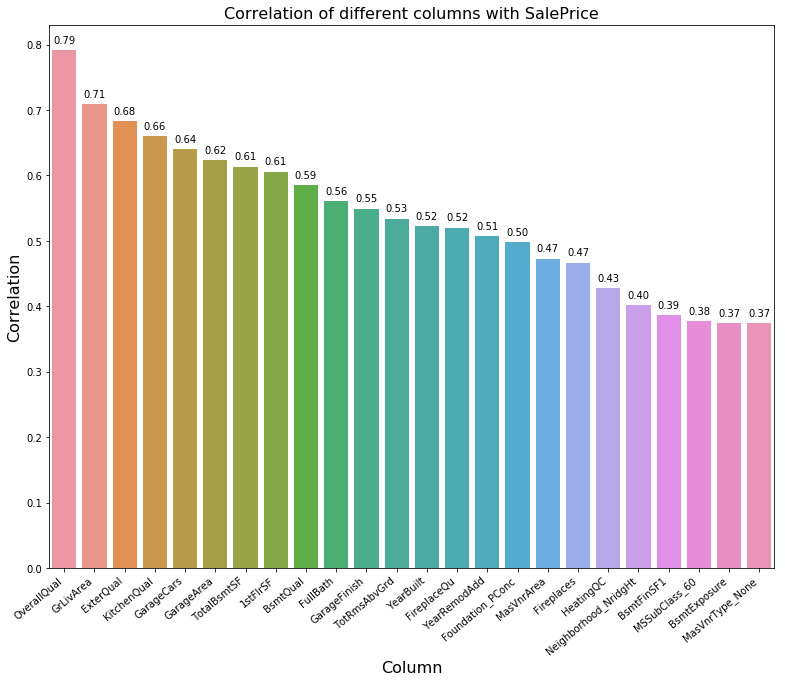

In [15]:
corrDF = paramsDF.corr(method="pearson").abs()

toPlot = corrDF['SalePrice'].sort_values(ascending=False)[1:25]

figure, ax = plt.subplots(figsize=(13,10))
ax = sns.barplot(x=toPlot.index, y=toPlot.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel('Column', fontsize= 16)
plt.ylabel('Correlation', fontsize= 16)
plt.title('Correlation of different columns with SalePrice', fontsize=16)

Here we can see that the top 5 columns with highest correlation with SalePrice are OverallQual, GrLivArea, ExterQual, KitchenQual, TotalBsmtSF and GarageCars. Let us take a closer look as to how they are correlated with SalePrice

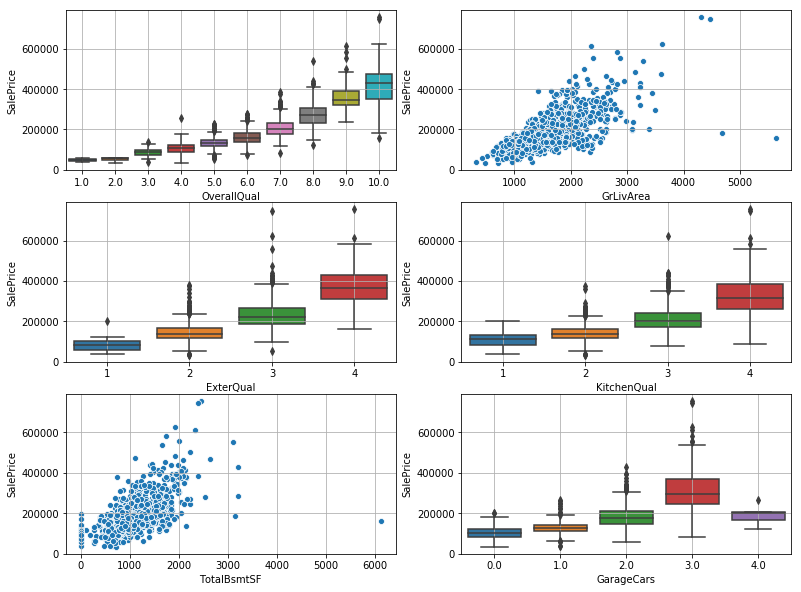

In [16]:
toPlot = correctedDF[['OverallQual','GrLivArea','ExterQual','KitchenQual','TotalBsmtSF','GarageCars','SalePrice']].copy()

plt.figure(figsize=(13,10))
plt.subplot(321)
sns.boxplot(data=correctedDF, x='OverallQual', y='SalePrice')
plt.grid()

plt.subplot(322)
sns.scatterplot(data=correctedDF, x='GrLivArea', y='SalePrice')
plt.grid()

plt.subplot(323)
sns.boxplot(data=correctedDF, x='ExterQual', y='SalePrice')
plt.grid()

plt.subplot(324)
sns.boxplot(data=correctedDF, x='KitchenQual', y='SalePrice')
plt.grid()

plt.subplot(325)
sns.scatterplot(data=correctedDF, x='TotalBsmtSF', y='SalePrice')
plt.grid()

plt.subplot(326)
sns.boxplot(data=correctedDF, x='GarageCars', y='SalePrice')
plt.grid()

Common for all the factors we are looking at here, is that the variance in SalePrice increases as each factor increases. With exception of GarageCars. Here the mean, and deviation in SalePrice drops drasticly as GarageCars increases from three to four. We will inspect that more closely later. The reason for this is just because there are very few properties in that category (only three).

## Normalizing SalePrice

Text(0.5,1,'Distribution of log(SalePrice)')

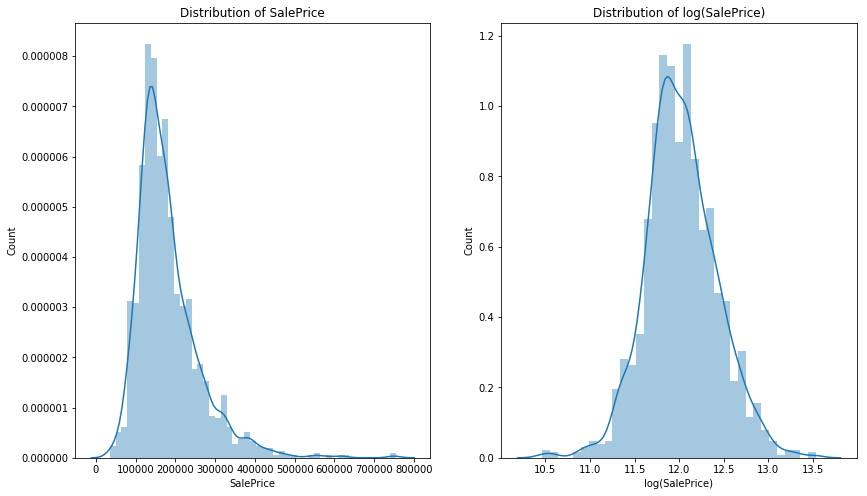

In [17]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.distplot(pricesRawDF['SalePrice'], ax=ax1)
sns.distplot(np.log(pricesRawDF['SalePrice']), ax=ax2)

ax1.set_ylabel('Count')
ax1.set_title('Distribution of SalePrice')

ax2.set_xlabel('log(SalePrice)')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of log(SalePrice)')

We noticed that SalePrice has a slightly skewed distribution. This is unfavorable for prediction. But, by taking the logarithm of SalePrice, the distribution is much closer to a normal distribution. So we will be using that further in our predictive models.

# Pre-processing
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

We don't create many new features, as it does not add any new information to the dataset. As predictive models only make better predictions if new information is added, or noise is removed it is not beneficial to create new columns from old ones without carefull consideration. 

## Feature selection

Many of the models we will be testing are linear models, or are made up of linear models. One of the basic assumptions in linear models is that the covariates that make up the design matrix are independant i.e. that the are not correlated. The higher the correlation between to covariates, the less "new information" they contribute with, and the more noise they add to the dataset. 

However, covariance is only a measure of linear dependance between to variables. For example, if one has two random variables $X$ and $Y$, and $Y$ is given by the equation below.

\begin{equation}
Y = X^2
\end{equation}

The correlation between $Y$ and $X$ will be zero, even though Y obviously is dependent of $X$. That is why it is risky to remove all parameters that are uncorrelated with SalePrice, because one risks loosing a lot of information. However, it is still expedient to remove coloumns that are highly correlated. As they add little information to the dataset, but add more noise.  

In [18]:
def remove_correlated_cols(trainDF, testDF, corr_limit):
    paramsDF = trainDF.copy()
    toReturnTrainDF = trainDF.copy()
    toReturnTestDF = testDF.copy()
    paramsDF.drop(['Id','SalePrice'], axis=1, inplace=True)
    priceCorr = trainDF.corr().abs()['SalePrice']
    corrDF = paramsDF.corr(method="pearson").abs()

    highly_correlated_columns = np.where(np.logical_and((corrDF > corr_limit),(corrDF < 1.0)))
    param_col_names = corrDF.columns
    redundant_cols = []
    correlatd_cols = []
    for index in range(len(highly_correlated_columns[0])):
        col_name1 = param_col_names[highly_correlated_columns[0][index]]
        col_name2 = param_col_names[highly_correlated_columns[1][index]]
        if (col_name1 not in redundant_cols) and (col_name2 not in redundant_cols):
            correlation = corrDF.iloc[highly_correlated_columns[0][index]][col_name2]
            correlatd_cols.append([col_name1, col_name2, correlation])
            #print(col_name1, col_name2, correlation)
            redundant_cols.append(col_name1)
            redundant_cols.append(col_name2)

    cols_to_remove = []
    for row in correlatd_cols:
        correlation1 = priceCorr[row[0]]
        correlation2 = priceCorr[row[1]]
        if correlation1 > correlation2:
            cols_to_remove.append(row[1])
        else:
            cols_to_remove.append(row[0])
    toReturnTrainDF.drop(cols_to_remove, axis=1, inplace=True)
    toReturnTestDF.drop(cols_to_remove, axis=1, inplace=True)
    return toReturnTrainDF, toReturnTestDF

#featureReducedTrainDF, featureReducedTestDF = remove_correlated_cols(correctedDF, correctedTestDF, 0.8)
#print('Nr. of cols removed = %i' %(correctedDF.shape[1] - featureReducedTrainDF.shape[1]))

# Model selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Before any model is selected, the dataframe needs to to be modified. A new dataframe "y" is created by copying SalePrice. Then SalePrice is dropped from the dataframe before it is split into training and testdata. 

In [19]:
# Creating our target dataset and removing SalePrice  
y = np.log(correctedDF['SalePrice'])  # copies SalePrice to a new dataframe and make it Gaussian distrubuted 
X = correctedDF.drop('SalePrice', axis=1)

In [20]:
from sklearn.model_selection import train_test_split

# Divide train data into train and validation sets

seed = 1
test_size = 0.20

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = test_size, random_state = seed)

## Preliminary evaluation of models

The root mean squared error will be used to score our models. It is implemented as a custom scoring function, and will be used in the K-Fold Cross Validation of the different models. There are 11 regression models in total. The different models are scored on the mean of the scores from the 10-fold cross validation. The best models will be chosen for hyperparameter optimazation in the next section. The different models are variations of common machine learning algorithms used to solve different problems. We use the regression variant of each model. Some models are more suited to bigger datasets and we assume they will not perform as good, but we chose to have a broad basis for preliminary evaluation which we could narrow down later. We use linear regression as a benchmark for the other models. Some of the models use ensemble techniques (GradientBoosting, RandomForest) to score better.

In [21]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer

In [25]:


#scoring function
def scoring_func(guess, predictions):
    difference = np.sqrt(mean_squared_error(guess,predictions))
    return difference

custom_scorer = make_scorer(scoring_func,greater_is_better=True)

# user variables to tune
folds   = 10

# hold different regression models in a single dictionary
models = {}
models["Linear"]        = LinearRegression()
models["Lasso"]         = Lasso()
models["ElasticNet"]    = ElasticNet()
models["KNN"]           = KNeighborsRegressor()
models["DecisionTree"]  = DecisionTreeRegressor()
models["SVR"]           = SVR()
models["AdaBoost"]      = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["RandomForest"]  = RandomForestRegressor()
models["ExtraTrees"]    = ExtraTreesRegressor()
models["XGB Regressor"] = xgb.XGBRegressor()

# 10-fold cross validation for each model
model_results = pd.DataFrame(columns=['ModelName', 'Mean', 'StandardDeviation'])
i = 0
for model_name in models:
    model   = models[model_name]
    k_fold  = KFold(n_splits=folds, random_state=seed)
    results = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=custom_scorer)
    model_results.loc[i] = [model_name, round(results.mean(), 3), round(results.std(), 3)]
    i += 1

### Results

In [26]:
model_results.sort_values(["Mean", "StandardDeviation"], inplace=True, ascending=[True, True])
model_results

,ModelName,Mean,StandardDeviation
2,XGB Regressor,0.126,0.020
6,GradientBoost,0.129,0.023
8,ExtraTrees,0.148,0.020
9,RandomForest,0.152,0.018
10,Linear,0.152,0.063
7,AdaBoost,0.169,0.024
3,ElasticNet,0.190,0.065
5,Lasso,0.195,0.068
4,DecisionTree,0.210,0.020
1,KNN,0.229,0.027


From the table we observe the rankings of the different models based on the mean. Most of the models perfom reasonable, with Gradient Boosting Regressor just ahead of XGB Regressor. Since these two models are very similar both in results and how they work, we will do hyperparameter optimization on both in the following section. We also note the performence of linear regression. As features who are highly correlated with other features are removed in the previous section, linear regression does significantly better that many of the more complex models. But first we visualize the predictions of our best models.

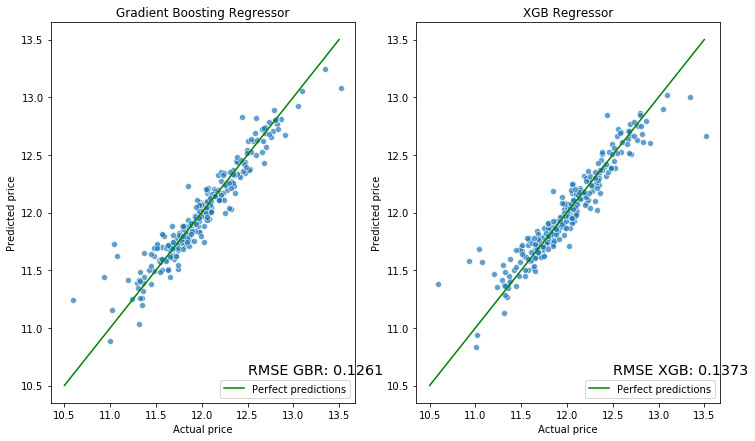

In [31]:
model_GBR = GradientBoostingRegressor()
model_GBR.fit(X_train, y_train)

model_XGB = xgb.XGBRegressor()
model_XGB.fit(X_train, y_train)

predictions_GBR = model_GBR.predict(X_test)
predictions_XGB = model_XGB.predict(X_test)

plt.figure(figsize=(12,7))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=predictions_GBR, alpha=0.7)
plt.plot([10.5,13.5],[10.5,13.5],"g", label='Perfect predictions')
plt.ylabel("Predicted price")
plt.xlabel("Actual price")
plt.title("Gradient Boosting Regressor")
plt.legend(loc='lower right')
scoreGBR = "RMSE GBR: {}".format(round(np.sqrt(mean_squared_error(predictions_GBR, y_test)), 4))
plt.annotate(s=scoreGBR,xy=(12.5,10.6),size='x-large')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=predictions_XGB, alpha=0.7)
plt.plot([10.5,13.5],[10.5,13.5],"g", label='Perfect predictions')
plt.ylabel("Predicted price")
plt.xlabel("Actual price")
plt.title("XGB Regressor")
plt.legend(loc='lower right')
scoreXGB = "RMSE XGB: {}".format(round(np.sqrt(mean_squared_error(predictions_XGB, y_test)), 4))
plt.annotate(s=scoreXGB,xy=(12.5,10.6),size='x-large')

plt.show()

The difference from RMSE values in the table and the plots are expected. In the plots the RMSE is calulated form the test data, while in the table it is the mean of 10-fold cross validation. Both models make worse predictions at relative higher and lower SalePrice compared to the median SalePrice. This is expected as there are less data in the two tales of the SalePrice distribution.

In [201]:
# Function for plotting the learning curve 
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

# Parameter optimisation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

To optimize the hyperparameters we use GridSearchCV. We optimize both models and compare the results. The final model will be the one with the lowest RMSE, but we will also plot the learning curve to look for overfitting.

In [202]:
#hyperparameter optimazation
from sklearn.model_selection import GridSearchCV

def hyperparameterOpt(estimator, params, cv, n_jobs=4):
    # Setting the grid of hyperparameters to search over, and searching over it, using GridSearchCV
    model_to_estimate = GridSearchCV(estimator = estimator, param_grid = params, cv = cv, n_jobs = n_jobs, verbose = 1)
    # Fits model on training data
    model_to_estimate.fit(X_train, Y_train)
    print("Best parameters from GridSearchCV: ", model_to_estimate.best_estimator_)
    # returns the model with the best parameters, ready for predicting
    return model_to_estimate.best_estimator_


The parameter grids underneath have been optimized earlier, and are set up this way for quick running times in the notebook. 

## ML-ensemble Stacking

In [22]:
# stacking 
from sklearn.kernel_ridge import KernelRidge


# models to stack
ab = AdaBoostRegressor()
gb = GradientBoostingRegressor() # n_estimators=[2200], learning_rate=0.01, max_depth=4, min_samples_leaf=5, max_features=0.08
rf = RandomForestRegressor()
et = ExtraTreesRegressor()
xgbr = xgb.XGBRegressor()
kr = KernelRidge()
# meta layer
lr = LinearRegression()


In [23]:
from mlxtend.regressor import StackingRegressor

sr = StackingRegressor(regressors = [ab, gb, rf, et, xgbr, kr], meta_regressor = lr) 

sr.fit(X_train, y_train)
sr_preds = sr.predict(X_test)

sr_score = np.sqrt(mean_squared_error(sr_preds, y_test))
print("RMSE Mlxtend Ensemble: {}".format(round(sr_score, 4)))

RMSE Mlxtend Ensemble: 0.1388


In [24]:
from mlens.ensemble import SuperLearner


ensemble = SuperLearner(random_state=seed, folds=5, verbose = 2)
# Build the first layer
ensemble.add([ab, gb, rf, et, xgbr, kr])
# Attach the final meta estimator
ensemble.add_meta(lr)

ensemble.fit(X_train, y_train)
ensemble_preds = ensemble.predict(X_test)

ensemble_score = np.sqrt(mean_squared_error(ensemble_preds, y_test))
print("RMSE Mlens Ensemble: {}".format(round(ensemble_score, 4)))

[MLENS] backend: threading



Fitting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:02

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00
RMSE Mlens Ensemble: 0.1266


# Conclusion
<hr style="height:1px;border:none;color:#333;background-color:#333;" /> 
In the end we achieve a RMSE of 0.126. The prediction is by no means perfect, and we still have a lot of variance in our model. There are still further work which could be done with this model. We could stack different models using a stacking regressor to include outliers in a better way. If we had more data, we could have used a model that could be better to capture non-linear relationships between SalePrice and the parameters.

# Submission
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

In [207]:
final_predictions = np.exp(best_parametersGBR.predict(featureReducedTestDF))
submission = pd.DataFrame()
submission['Id'] = featureReducedTestDF['Id']
submission['SalePrice'] = final_predictions
submission.head(5)

,Id,SalePrice
0,1201,104612.536032
1,1202,199377.279814
2,1203,134677.686142
3,1204,204914.667531
4,1205,149483.993706


In [208]:
submission.to_csv('submission_final_group31.csv', index=False)